<a href="https://colab.research.google.com/github/Vejni/Capsules_Thesis/blob/main/PyTorchCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import numpy as np
import random
import time

In [ ]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(123)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
BATCH_SIZE = 32
IMG_WIDTH = 228
IMG_HEIGHT = 228
CROPPED_SIZE = 128
TRAINING_SET = 0.8
TRAIN_DATA_PATH = "./gdrive/MyDrive/Histopathological_Graded/"
EPOCHS = 50
MODEL_NAME = "PyTorch_CNN_Epochs100" + str(int(time.time()))

In [ ]:
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  # image
        y = self.dataset[index][1]   # label      
        return x, y

    def __len__(self):
        return len(self.dataset)

In [ ]:
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import PIL

training_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH,IMG_HEIGHT)),
    transforms.CenterCrop(CROPPED_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5] )
    ])

validation_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.CenterCrop(CROPPED_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5] )
    ])

data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=None)

train_size = int(TRAINING_SET*len(data))
val_size = len(data) - train_size
train_data, validation_data = torch.utils.data.random_split(data, [train_size, val_size])

train_data = MapDataset(train_data, training_transforms)
validation_data = MapDataset(validation_data, training_transforms)

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_data_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)

print(len(train_data), len(validation_data))

737 185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


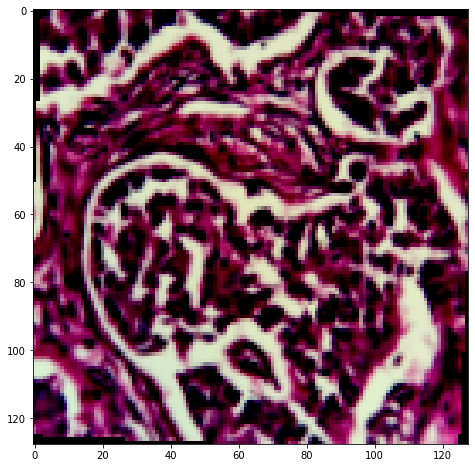

tensor(1)
torch.Size([3, 128, 128])


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
import random

index = random.randint(0, 31)
temp = next(iter(train_data_loader))
img = temp[0][index]
label = temp[1][index]

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

print(label)
print(img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


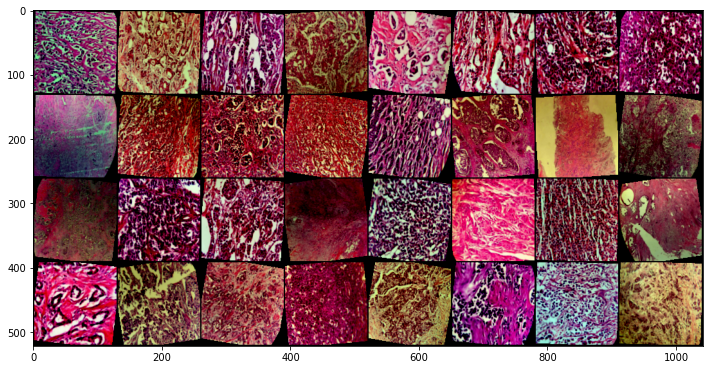

tensor([0, 0, 2, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2, 2, 1, 2, 2, 2, 1, 2, 1,
        1, 2, 1, 2, 0, 1, 2, 0])

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_data_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
labels

In [ ]:
############################################################################################################# Small CNN #########################################################################################################

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, no_channels, no_classes):
        super(Net, self).__init__()
        self.cnn_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(no_channels, 32, kernel_size=5, stride=1), # bias=False,
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 1),

            # Convolutional Layer 2
            nn.Conv2d(32, 32, kernel_size=5, stride=1), # bias=False
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 1),

            # Convolutional Layer 3
            #nn.Conv2d(64, 128, kernel_size=5, stride=1, bias=False),
            #nn.BatchNorm2d(128),
            #nn.ReLU(inplace=True),
            #nn.MaxPool2d(3, 1),

            # And flatten
            # nn.Flatten()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(32 * 116 * 116, 64),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(64, 64),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            nn.Linear(64, no_classes) # NO softmax, bc it is in crossentropy loss
        )
        

    def forward(self, x):
        x = self.cnn_layers(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


model = Net(no_channels=3, no_classes=3)
model.to(device)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=430592, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001) # weight_decay=1e-7

In [ ]:
"""
model.train()
for data, target in train_data_loader:
    # move-tensors-to-GPU 
    data = data.to(device)
    target = target.to(device)

    # clear-the-gradients-of-all-optimized-variables
    optimizer.zero_grad()
    # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
    output = model(data)

    # calculate-the-batch-loss
    loss = criterion(output, target)

    print(output, target, loss)
    break
"""

'\nmodel.train()\nfor data, target in train_data_loader:\n    # move-tensors-to-GPU \n    data = data.to(device)\n    target = target.to(device)\n\n    # clear-the-gradients-of-all-optimized-variables\n    optimizer.zero_grad()\n    # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model\n    output = model(data)\n\n    # calculate-the-batch-loss\n    loss = criterion(output, target)\n\n    print(output, target, loss)\n    break\n'

In [ ]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []
train_acc = []
val_acc = []

for epoch in range(1, EPOCHS + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    
    # training-the-model
    model.train()
    for data, target in train_data_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        # Accuracy
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).float().sum()
        train_total += target.size(0)

    # validate-the-model
    model.eval()
    for data, target in val_data_loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        # update-average-validation-loss 
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

        # Accuracy
        _, predicted = torch.max(output.data, 1)
        valid_correct += (predicted == target).float().sum()
        valid_total += target.size(0)

    # calculate-average-losses
    train_loss = train_loss/len(train_data_loader.sampler)
    valid_loss = valid_loss/len(val_data_loader.sampler)
    train_accuracy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    val_acc.append(valid_accuracy)

    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.6f} \tValidation Loss: {:.6f} \tValidation Acc: {:.6f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, valid_accuracy))

Training Finished
Validation Finished
Epoch: 1 	Training Loss: 1.070255 	Training Acc: 0.383989 	Validation Loss: 1.086038 	Validation Acc: 0.394595
Training Finished
Validation Finished
Epoch: 2 	Training Loss: 1.047765 	Training Acc: 0.439620 	Validation Loss: 1.108977 	Validation Acc: 0.340541
Training Finished
Validation Finished
Epoch: 3 	Training Loss: 1.047878 	Training Acc: 0.401628 	Validation Loss: 1.072119 	Validation Acc: 0.389189
Training Finished
Validation Finished
Epoch: 4 	Training Loss: 1.037813 	Training Acc: 0.420624 	Validation Loss: 1.072077 	Validation Acc: 0.400000
Training Finished
Validation Finished
Epoch: 5 	Training Loss: 1.031272 	Training Acc: 0.459973 	Validation Loss: 1.117656 	Validation Acc: 0.400000
Training Finished
Validation Finished
Epoch: 6 	Training Loss: 1.037209 	Training Acc: 0.447761 	Validation Loss: 1.112160 	Validation Acc: 0.405405
Training Finished
Validation Finished
Epoch: 7 	Training Loss: 1.047977 	Training Acc: 0.430122 	Validatio

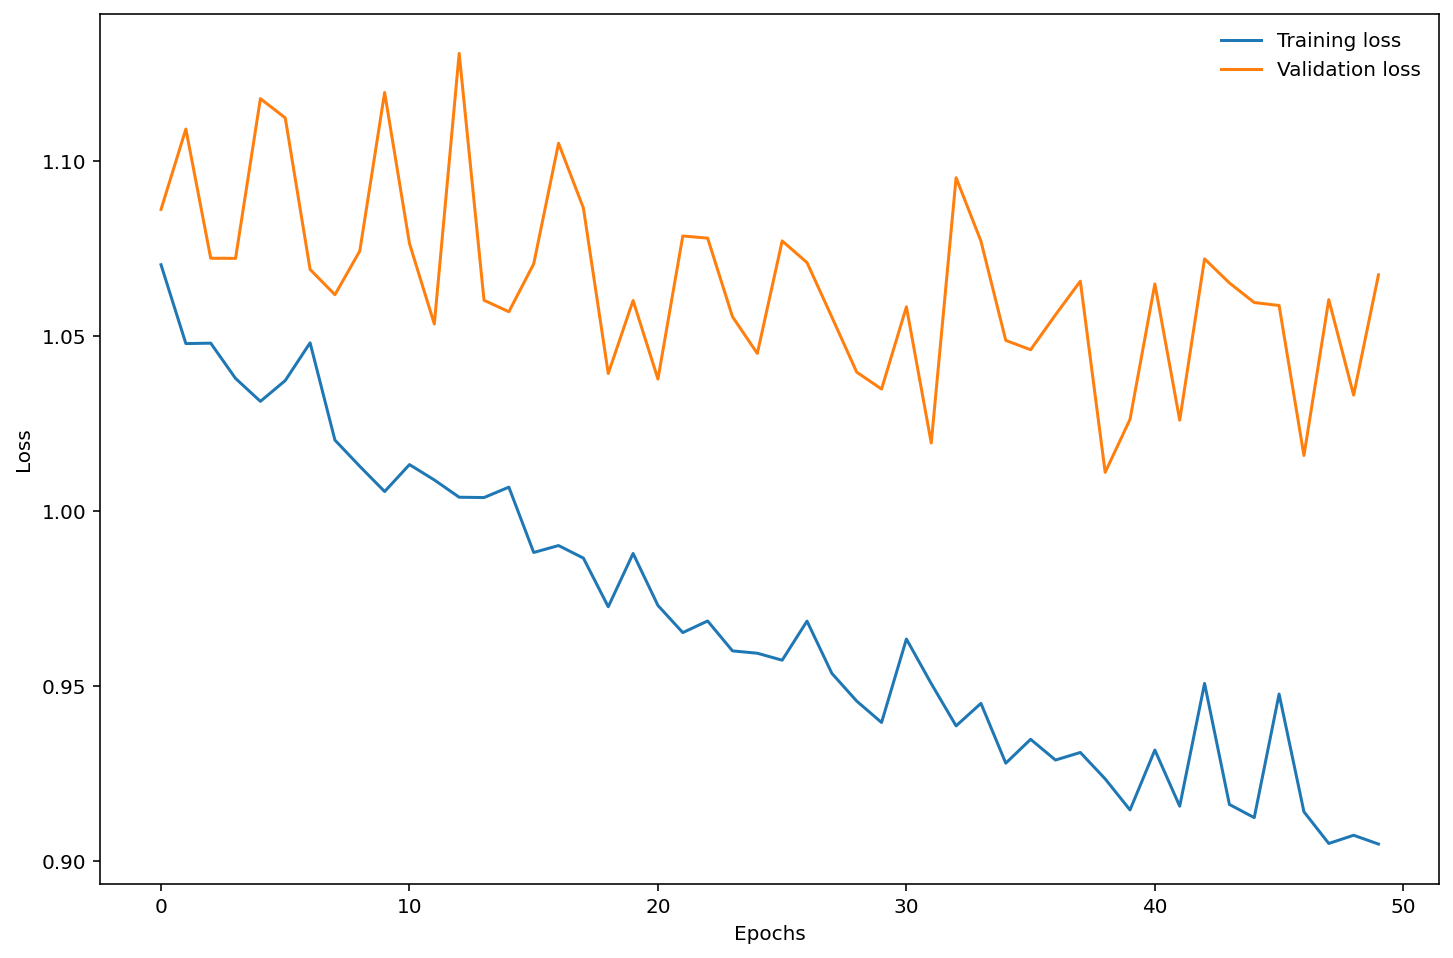

In [ ]:
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

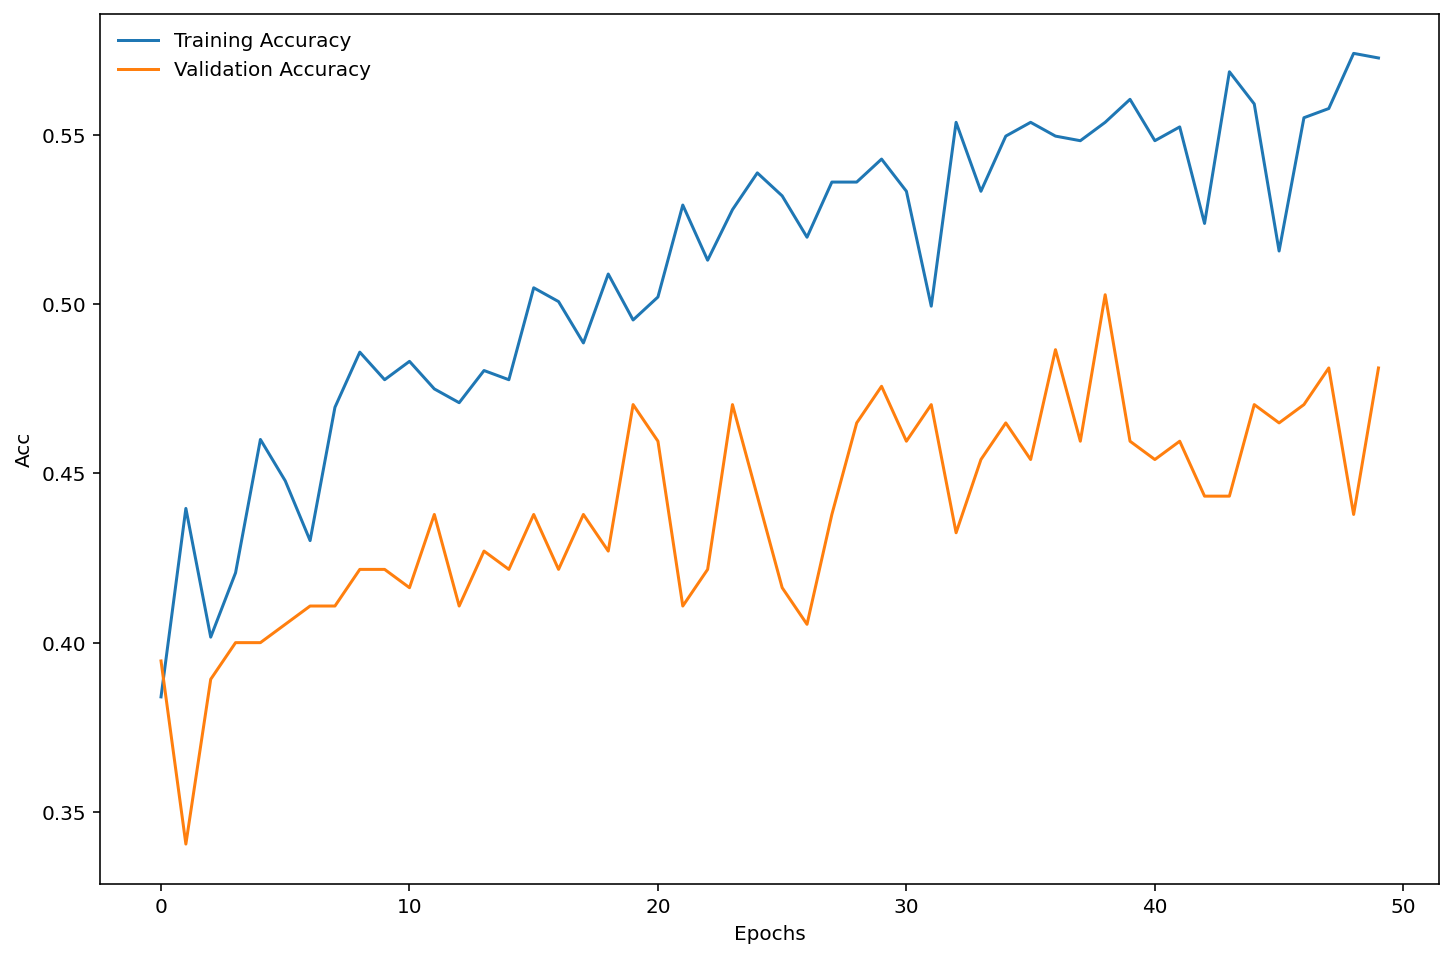

In [ ]:
%config InlineBackend.figure_format = 'retina'

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend(frameon=False)

In [ ]:
import pickle


with open("./gdrive/MyDrive/Models/Stats/" + MODEL_NAME + ".txt", "wb") as fp:
    pickle.dump(train_losses, fp)
    pickle.dump(train_acc, fp)
    pickle.dump(valid_losses, fp)
    pickle.dump(val_acc, fp)

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Train Accuracy of the model: {} %'.format(100 * correct / total))

    correct = 0
    total = 0
    for images, labels in val_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Train Accuracy of the model: 56.98778833107191 %
Test Accuracy of the model: 40.54054054054054 %


In [ ]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for images, labels in val_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 57 %
Accuracy of     1 : 70 %
Accuracy of     2 :  0 %


In [ ]:
# Save 
torch.save(model_ft.state_dict(), './gdrive/MyDrive/Models/' + MODEL_NAME + '.ckpt')



*   https://medium.com/pytorch/accelerate-your-hyperparameter-optimization-with-pytorchs-ecosystem-tools-bc17001b9a49
* learning rate scheduler
* https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9

